## Gaussian Process Regression

What is the objective? <br>
Like in any regression, you have some data, some point and you have some predictor variable x and response variable y. You have some points you know(observations) and the aim to to find a structure, the funtion that fits these points. There can be many function that can pass through those same set of points.  here we are sampling 30 points. there can be many functions that can pass through those points. Gaussian process Regression in a way is a distribution over a function. You can draw different functions that passes through those points. but it can also be generalized to functions that have noise and it passes as close as possible to them.
<br>
Gaussian processes are a powerful tool in the machine learning toolbox
[1]
. They allow us to make predictions about our data by incorporating prior knowledge.

#### General Form:
We have two parameters, mean and covariance parameters.
$$\mu = K^* K^{-1} y$$
mean is a combination of values that we already have(we have some data and corresponding y values for them). 
$K^{-1}$mean that we generate will be some combination of those y. These combination will be weighted by some matrix. <br>
$K^{*}$ :One component in the matrix will be the interaction between the x's of our training data. and the other part is how much of the new points are co-related to the points that we do have in our training data.<br>
If we were to put the same points that we have, i.e., $K^* = K$, which implies mean is the same as the training data points
Covariance
$$\mathbb{V} = K^{**} - K^* K^{-1} K^{*T}$$
$K^{**}$ captures the realation between the new points and themselves<br>
$K^* K^{-1}K^{*T}$ Captures the relation between the new point and the old points, it reduces the variance that are closer to the points that we already know of.<br>

So once we have the mean, we can draw the line which will represent the mean of all possible functions and variance gives confidence interval at each value. This condidence interval will be zero at the observations.

How do we get the above equations?<br>
1st way is Kernel First View<br>
We presume that there is some structure in our data, i.e., $y = f(x)$<br>
in this view, the Gaussian Process is defined as an infinite space of gaussian variables, that is any subset in this space will be a gaussian distribution. They have some mean and kernel function which tells how much the points are related. In kernel first view, we first find the kernel matrix. This kernel gives the smooth function. We can plot random realization from a MVN distribution with mean 0 and cov = K. It is also call GP prior. but we want to incorporate data that we have.

2nd View Prior<br>
Let $y = f(x) + \epsilon$, $f(x) = x^Tw$

In [133]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.metrics
import scipy
import scipy.io
from matplotlib import cm

np.set_printoptions(precision = 3)

In [134]:
bat = scipy.io.loadmat('Synthetic_LiPo_PulseDischarge.mat')

# collecting data for the first current pulse
voltage = bat['voltage'][0:200]
current = bat['current'][0:200]
time = bat['time'][0:200]

In [221]:
# Choosing the training points
rng = np.random.RandomState(1)
training_indices = rng.choice(np.squeeze(time), size=20, replace=False)
time_train, voltage_train = time[np.sort(training_indices)], voltage[np.sort(training_indices)]

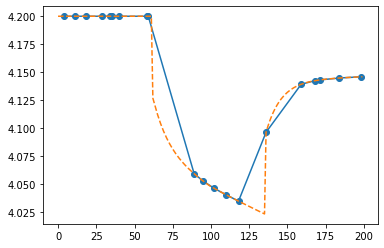

In [222]:
plt.scatter(time_train, voltage_train)    # training Points
plt.plot(time_train, voltage_train)
plt.plot(time, voltage, '--')

In [223]:
# Testing data
n_test = 100
testing_indices = np.zeros(n_test)

i = 0
while i < n_test:
    dummy = rng.choice(np.squeeze(time), size  = 1)
    if dummy in training_indices:
        continue
    else:
        testing_indices[i] = dummy
        i += 1

testing_indices = np.sort(testing_indices).astype(int)
time_test, voltage_test = time[testing_indices].reshape(-1, 1), voltage[testing_indices].reshape(-1, 1)


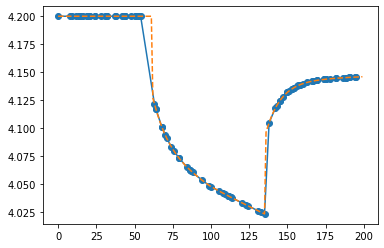

In [224]:
# Testing data
plt.scatter(time_test, voltage_test)
plt.plot(time_test, voltage_test)
plt.plot(time, voltage, '--')

In [225]:
# Defining the Kernel Function
def RBF_kernel(a, b, sig_var, l):
    """
    Using RBF Kernel K(x_i, x_j) = sigma * exp(-0.5 * ||x_i - x_j||^2/l)
    """
    
    distance = sklearn.metrics.pairwise_distances(a, b)
    RBF = (sig_var)**2 * np.exp(-0.5 * (distance)**2/l**2)
    return RBF

Text(0.5, 1.0, '5 samples from GP prior')

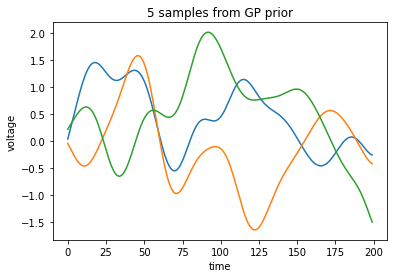

In [226]:
# Getting Prior with the test points
K_ss = RBF_kernel(time, time, 1, 15)

voltage_prior = np.random.multivariate_normal(mean = np.zeros(time.shape[0]), cov = K_ss, size = 3).T
#Plotting 5 sampled functions
plt.plot(time, voltage_prior)
plt.xlabel('time')
plt.ylabel('voltage')
plt.title('5 samples from GP prior')

In [227]:
# Applying Kernel to our training points
K = RBF_kernel(time_train, time_train, 1, 15)

L = np.linalg.cholesky(K)
C = np.linalg.inv(L)
K_inv = np.dot(C.T, C)

# kernel comparing training and testing data
K_s = RBF_kernel(time_train, time, 1, 15)

# Computing mean
mu = (K_s.T @ K_inv @ voltage_train).squeeze()

# computing Covariance
cov = K_ss - K_s.T @ K_inv @ K_s

# computing standard deviation(sqrt of diagonal values of cov matrix)
std_dev = np.sqrt(np.diag(cov)).squeeze()

/tmp/ipykernel_23295/967217391.py:18: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(np.diag(cov)).squeeze()


In [235]:
cov

array([[ 6.053e-04,  3.703e-04,  1.970e-04, ..., -6.312e-06, -1.950e-14,
         7.189e-06],
       [ 3.703e-04,  2.267e-04,  1.207e-04, ..., -3.983e-06, -1.306e-14,
         4.537e-06],
       [ 1.970e-04,  1.207e-04,  6.431e-05, ..., -2.187e-06, -8.381e-15,
         2.491e-06],
       ...,
       [-6.312e-06, -3.983e-06, -2.187e-06, ...,  3.966e-04,  3.442e-15,
        -4.864e-04],
       [-2.866e-15, -2.149e-15, -1.663e-15, ...,  4.996e-15,  4.552e-15,
         3.997e-15],
       [ 7.189e-06,  4.537e-06,  2.491e-06, ..., -4.864e-04,  4.552e-15,
         5.992e-04]])

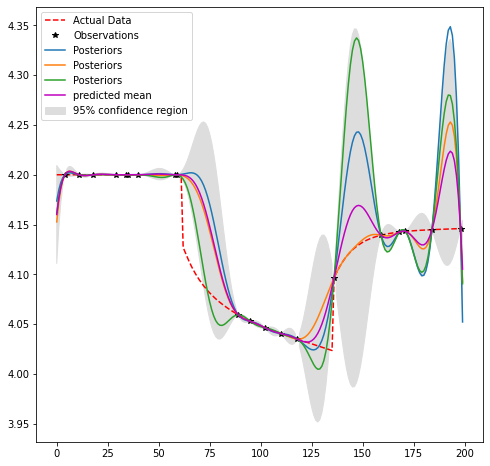

In [234]:
# we draw samples from our posterior at our test points with mean = mu and covariance = cov
voltage_post = np.random.multivariate_normal(mean = mu.squeeze(), cov = cov, size = 3).T

plt.figure(figsize = (8, 8))
plt.plot(time, voltage, '--r', label = 'Actual Data')
plt.plot(time_train, voltage_train, '*k', ms = 6, label = 'Observations')
plt.plot(time, voltage_post, label = 'Posteriors')
plt.plot(time, mu, 'm', label = 'predicted mean')
plt.gca().fill_between(time.flat, mu - 2 * std_dev, mu + 2 * std_dev, color = '#dddddd', label = '95% confidence region')
plt.legend()

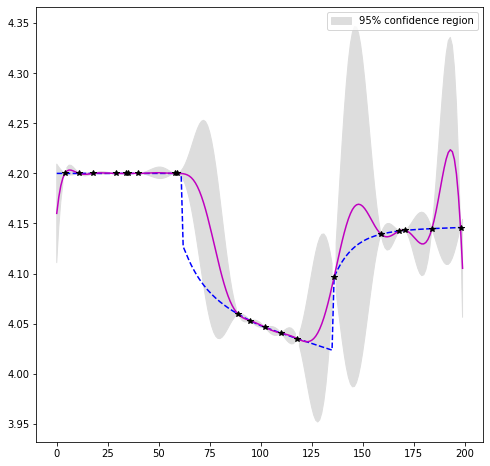

In [230]:
plt.figure(figsize = (8, 8))
plt.plot(time, voltage, '--b')
plt.plot(time, mu, 'm')
plt.plot(time_train, voltage_train, '*k')
plt.gca().fill_between(time.flat, mu - 2 * std_dev, mu + 2 * std_dev, color = '#dddddd', label = '95% confidence region')
plt.legend()

In [186]:
voltage_train.shape

(25, 1)

In [200]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [201]:
kernel = RBF(length_scale=5.0, length_scale_bounds=(1e-2, 1e5))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(time_train, voltage_train)
gaussian_process.kernel_

/home/aman/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=16.2)

In [189]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(voltage, mu)
print(mse)

0.0015053579039737664
